# Newmark数值积分法详解与算例

Newmark方法是结构动力学中常用的时间步积分方法，用于求解结构的动力响应。该方法由N.M. Newmark于1959年提出，是一类隐式积分方法，广泛应用于地震工程和结构动力学分析中。

## 1. Newmark方法的理论基础

Newmark方法基于以下位移和速度的迭代公式：

$$u_{n+1} = u_n + \Delta t \dot{u}_n + \frac{\Delta t^2}{2}[(1-2\beta)\ddot{u}_n + 2\beta\ddot{u}_{n+1}]$$

$$\dot{u}_{n+1} = \dot{u}_n + \Delta t[(1-\gamma)\ddot{u}_n + \gamma\ddot{u}_{n+1}]$$

其中：
- $u$, $\dot{u}$, $\ddot{u}$ 分别表示位移、速度和加速度
- $\Delta t$ 是时间步长
- $\beta$ 和 $\gamma$ 是控制积分精度和稳定性的参数
  - 当 $\gamma = 1/2, \beta = 1/4$ 时，为平均加速度法（无条件稳定）
  - 当 $\gamma = 1/2, \beta = 1/6$ 时，为线性加速度法（条件稳定）

## 2. 单自由度系统的Newmark方法求解

单自由度系统的运动方程为：

$$m\ddot{u} + c\dot{u} + ku = p(t)$$

其中：
- $m$ 是质量
- $c$ 是阻尼系数
- $k$ 是刚度
- $p(t)$ 是外部荷载

下面我们将导入必要的库并设置一个算例来演示Newmark方法的应用。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 设置绘图样式
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 3. 算例设置 - 单自由度系统

我们考虑一个受简谐外力作用的单自由度弹簧-质量-阻尼系统。该系统的参数如下：

In [2]:
# 系统参数
m = 1.0       # 质量 (kg)
k = 100.0     # 刚度 (N/m)
xi = 0.05     # 阻尼比
omega_n = np.sqrt(k/m)  # 自然频率 (rad/s)
c = 2 * xi * m * omega_n  # 阻尼系数 (N·s/m)

# 计算周期
T_n = 2 * np.pi / omega_n
print(f"系统自然周期: {T_n:.4f} 秒")

# 外部荷载参数
F_0 = 10.0    # 荷载幅值 (N)
omega_f = 0.8 * omega_n  # 荷载频率 (rad/s)

# 模拟参数
t_final = 5 * T_n  # 模拟持续时间（五个周期）

# 外部荷载函数
def force_function(t):
    return F_0 * np.sin(omega_f * t)

系统自然周期: 0.6283 秒


## 4. Newmark方法的实现

下面我们实现Newmark法求解上述系统的响应：

In [3]:
def newmark_method(m, c, k, p_func, u0, v0, t_final, dt, beta=0.25, gamma=0.5):
    """
    使用Newmark-β方法求解单自由度系统的动力响应
    
    参数:
        m: 质量
        c: 阻尼系数
        k: 刚度
        p_func: 外部荷载函数
        u0: 初始位移
        v0: 初始速度
        t_final: 模拟终止时间
        dt: 时间步长
        beta: Newmark参数β，默认0.25（平均加速度法）
        gamma: Newmark参数γ，默认0.5
    
    返回:
        t: 时间数组
        u: 位移数组
        v: 速度数组
        a: 加速度数组
    """
    # 计算步数
    n_steps = int(t_final / dt) + 1
    
    # 初始化结果数组
    t = np.linspace(0, t_final, n_steps)
    u = np.zeros(n_steps)
    v = np.zeros(n_steps)
    a = np.zeros(n_steps)
    
    # 初始条件
    u[0] = u0
    v[0] = v0
    a[0] = (p_func(0) - c * v[0] - k * u[0]) / m
    
    # Newmark方法的常数
    a1 = 1.0 / (beta * dt * dt)
    a2 = 1.0 / (beta * dt)
    a3 = (1.0 - 2.0 * beta) / (2.0 * beta)
    a4 = gamma / (beta * dt)
    a5 = 1.0 - gamma/beta
    a6 = dt * (1.0 - gamma/(2.0*beta))
    
    k_hat = k + a1 * m + a4 * c
    
    # 迭代求解
    for i in range(1, n_steps):
        # 计算等效荷载
        p_hat = p_func(t[i]) + m * (a1 * u[i-1] + a2 * v[i-1] + a3 * a[i-1]) + \
                c * (a4 * u[i-1] + a5 * v[i-1] + a6 * a[i-1])
        
        # 计算当前步的位移
        u[i] = p_hat / k_hat
        
        # 更新加速度和速度
        a[i] = a1 * (u[i] - u[i-1] - dt * v[i-1]) - a3 * a[i-1]
        v[i] = v[i-1] + dt * ((1 - gamma) * a[i-1] + gamma * a[i])
    
    return t, u, v, a

## 5. 不同时间步长下的精度和稳定性分析

现在我们使用不同的时间步长来求解系统响应，并比较结果。我们将设置三种不同的时间步长来观察Newmark方法的性能。

In [4]:
# 设置初始条件
u0 = 0.0  # 初始位移
v0 = 0.0  # 初始速度

# 创建不同的时间步长
dt1 = T_n / 50  # 较小的时间步长
dt2 = T_n / 20  # 中等时间步长
dt3 = T_n / 5   # 较大的时间步长

print(f"时间步长设置:")
print(f"dt1 = T_n/50 = {dt1:.6f} 秒")
print(f"dt2 = T_n/20 = {dt2:.6f} 秒")
print(f"dt3 = T_n/5 = {dt3:.6f} 秒")

时间步长设置:
dt1 = T_n/50 = 0.012566 秒
dt2 = T_n/20 = 0.031416 秒
dt3 = T_n/5 = 0.125664 秒


/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/11501908.py:46: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/11501908.py:46: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/11501908.py:46: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/11501908.py:46: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/11501908.py:46: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/115019

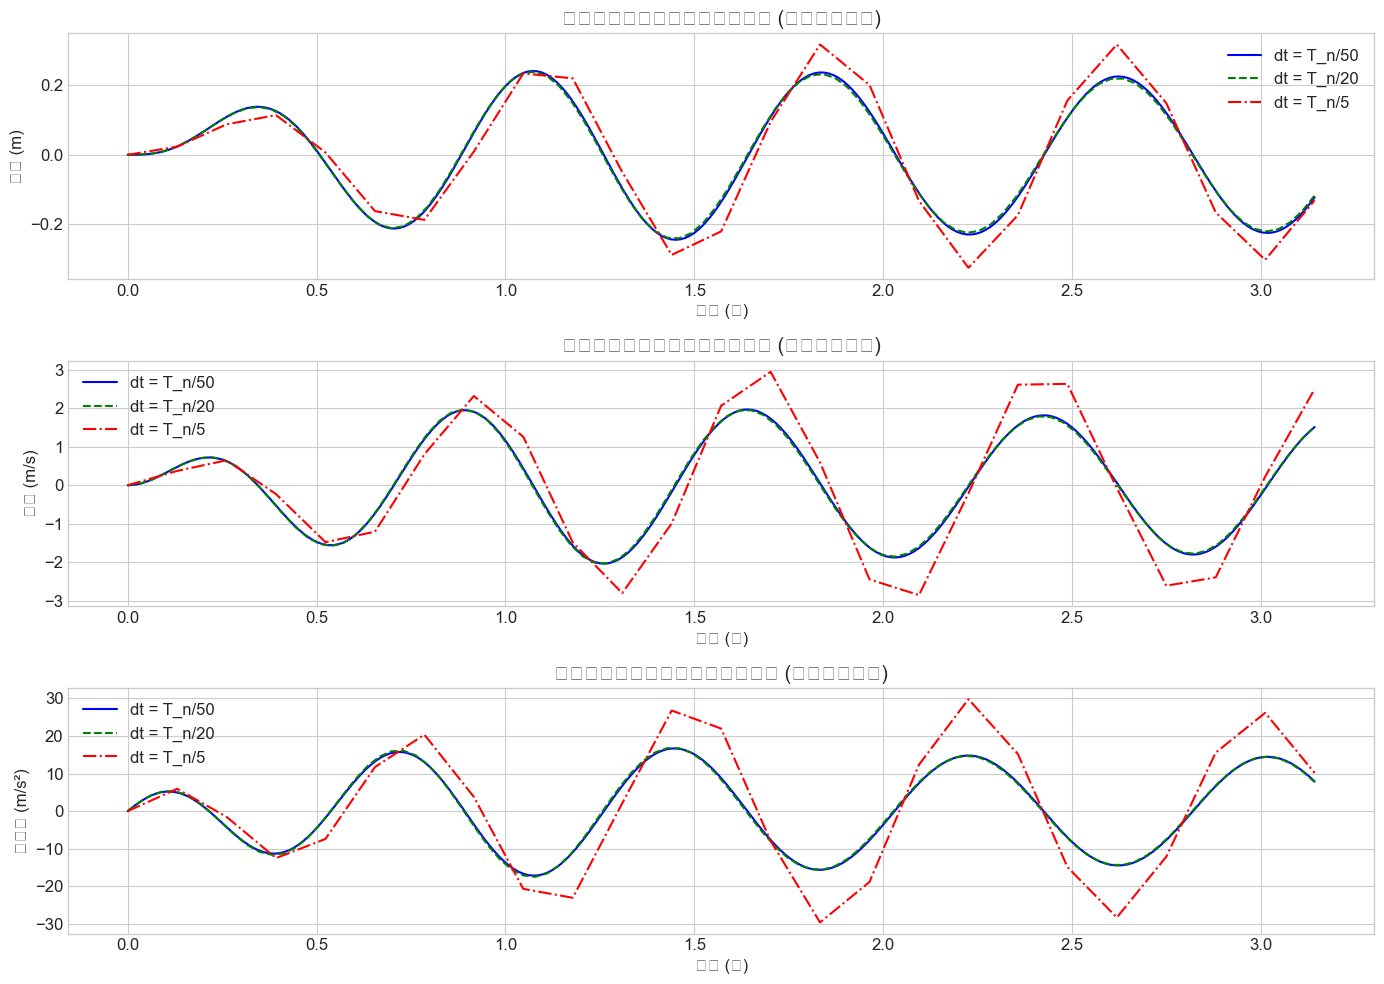

In [5]:
# 平均加速度法 (β=0.25, γ=0.5)
beta_avg = 0.25
gamma_avg = 0.5

# 使用不同时间步长进行计算
t1, u1, v1, a1 = newmark_method(m, c, k, force_function, u0, v0, t_final, dt1, beta_avg, gamma_avg)
t2, u2, v2, a2 = newmark_method(m, c, k, force_function, u0, v0, t_final, dt2, beta_avg, gamma_avg)
t3, u3, v3, a3 = newmark_method(m, c, k, force_function, u0, v0, t_final, dt3, beta_avg, gamma_avg)

# 对比可视化
plt.figure(figsize=(14, 10))

# 位移对比
plt.subplot(3, 1, 1)
plt.plot(t1, u1, 'b-', label=f'dt = T_n/50')
plt.plot(t2, u2, 'g--', label=f'dt = T_n/20')
plt.plot(t3, u3, 'r-.', label=f'dt = T_n/5')
plt.xlabel('时间 (秒)')
plt.ylabel('位移 (m)')
plt.title('不同时间步长下的位移响应对比 (平均加速度法)')
plt.legend()
plt.grid(True)

# 速度对比
plt.subplot(3, 1, 2)
plt.plot(t1, v1, 'b-', label=f'dt = T_n/50')
plt.plot(t2, v2, 'g--', label=f'dt = T_n/20')
plt.plot(t3, v3, 'r-.', label=f'dt = T_n/5')
plt.xlabel('时间 (秒)')
plt.ylabel('速度 (m/s)')
plt.title('不同时间步长下的速度响应对比 (平均加速度法)')
plt.legend()
plt.grid(True)

# 加速度对比
plt.subplot(3, 1, 3)
plt.plot(t1, a1, 'b-', label=f'dt = T_n/50')
plt.plot(t2, a2, 'g--', label=f'dt = T_n/20')
plt.plot(t3, a3, 'r-.', label=f'dt = T_n/5')
plt.xlabel('时间 (秒)')
plt.ylabel('加速度 (m/s²)')
plt.title('不同时间步长下的加速度响应对比 (平均加速度法)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. 不同Newmark参数的稳定性对比

现在我们比较不同的Newmark参数设置对结果的影响。主要比较平均加速度法与线性加速度法的区别。

/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/3158952429.py:35: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/3158952429.py:35: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/3158952429.py:35: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/3158952429.py:35: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/3158952429.py:35: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8

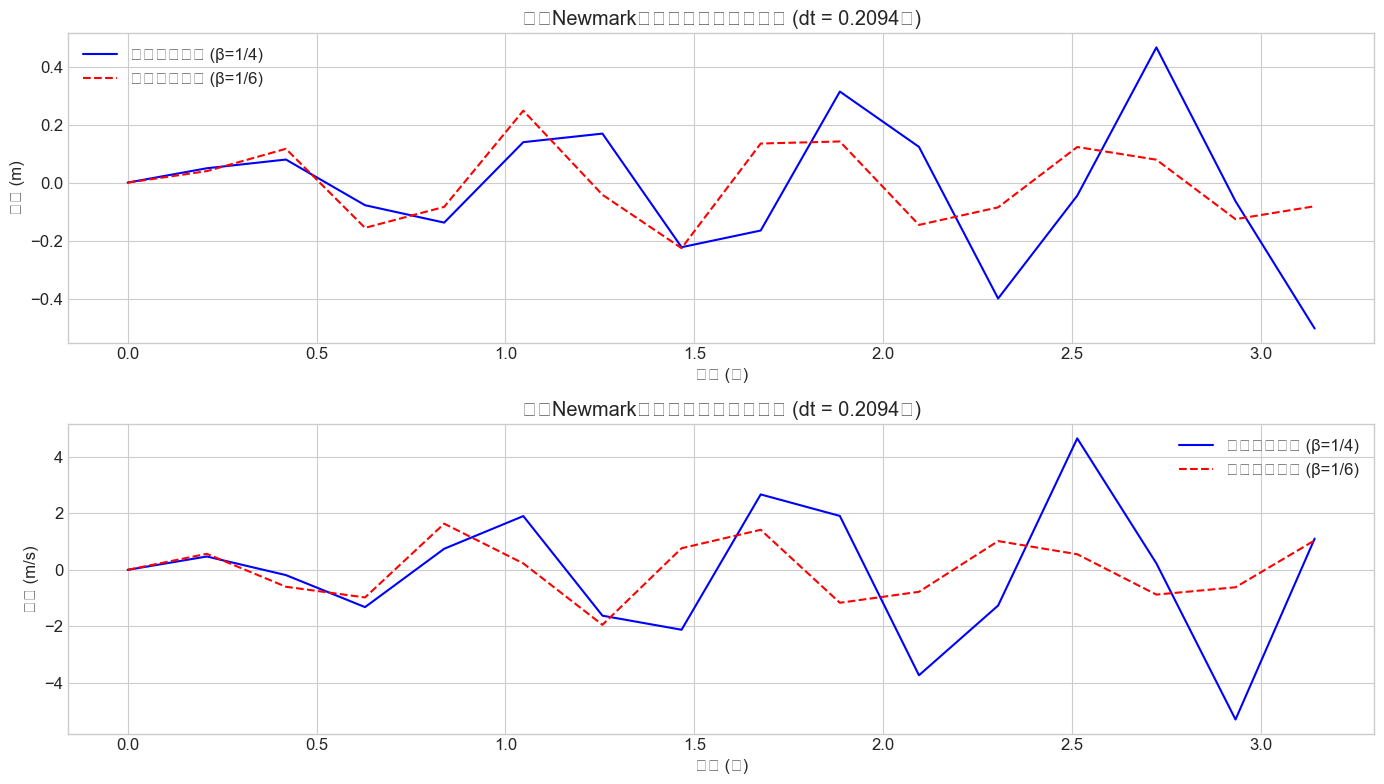

In [6]:
# 线性加速度法参数 (β=1/6, γ=1/2)
beta_linear = 1/6
gamma_linear = 0.5

# 使用较大时间步长计算，以观察稳定性差异
dt_large = T_n / 3  # 一个较大的时间步长，可能会导致线性加速度法不稳定

# 平均加速度法（无条件稳定）
t_avg, u_avg, v_avg, a_avg = newmark_method(m, c, k, force_function, u0, v0, t_final, dt_large, beta_avg, gamma_avg)

# 线性加速度法（条件稳定）
t_lin, u_lin, v_lin, a_lin = newmark_method(m, c, k, force_function, u0, v0, t_final, dt_large, beta_linear, gamma_linear)

# 对比可视化
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t_avg, u_avg, 'b-', label='平均加速度法 (β=1/4)')
plt.plot(t_lin, u_lin, 'r--', label='线性加速度法 (β=1/6)')
plt.xlabel('时间 (秒)')
plt.ylabel('位移 (m)')
plt.title(f'不同Newmark参数下的位移响应对比 (dt = {dt_large:.4f}秒)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_avg, v_avg, 'b-', label='平均加速度法 (β=1/4)')
plt.plot(t_lin, v_lin, 'r--', label='线性加速度法 (β=1/6)')
plt.xlabel('时间 (秒)')
plt.ylabel('速度 (m/s)')
plt.title(f'不同Newmark参数下的速度响应对比 (dt = {dt_large:.4f}秒)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. 与精确解进行对比

为了验证Newmark方法的准确性，我们将其结果与scipy.integrate.solve_ivp的高精度解法进行对比：

/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/1135938699.py:44: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/1135938699.py:44: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/1135938699.py:44: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/1135938699.py:44: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8490/1135938699.py:44: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_8

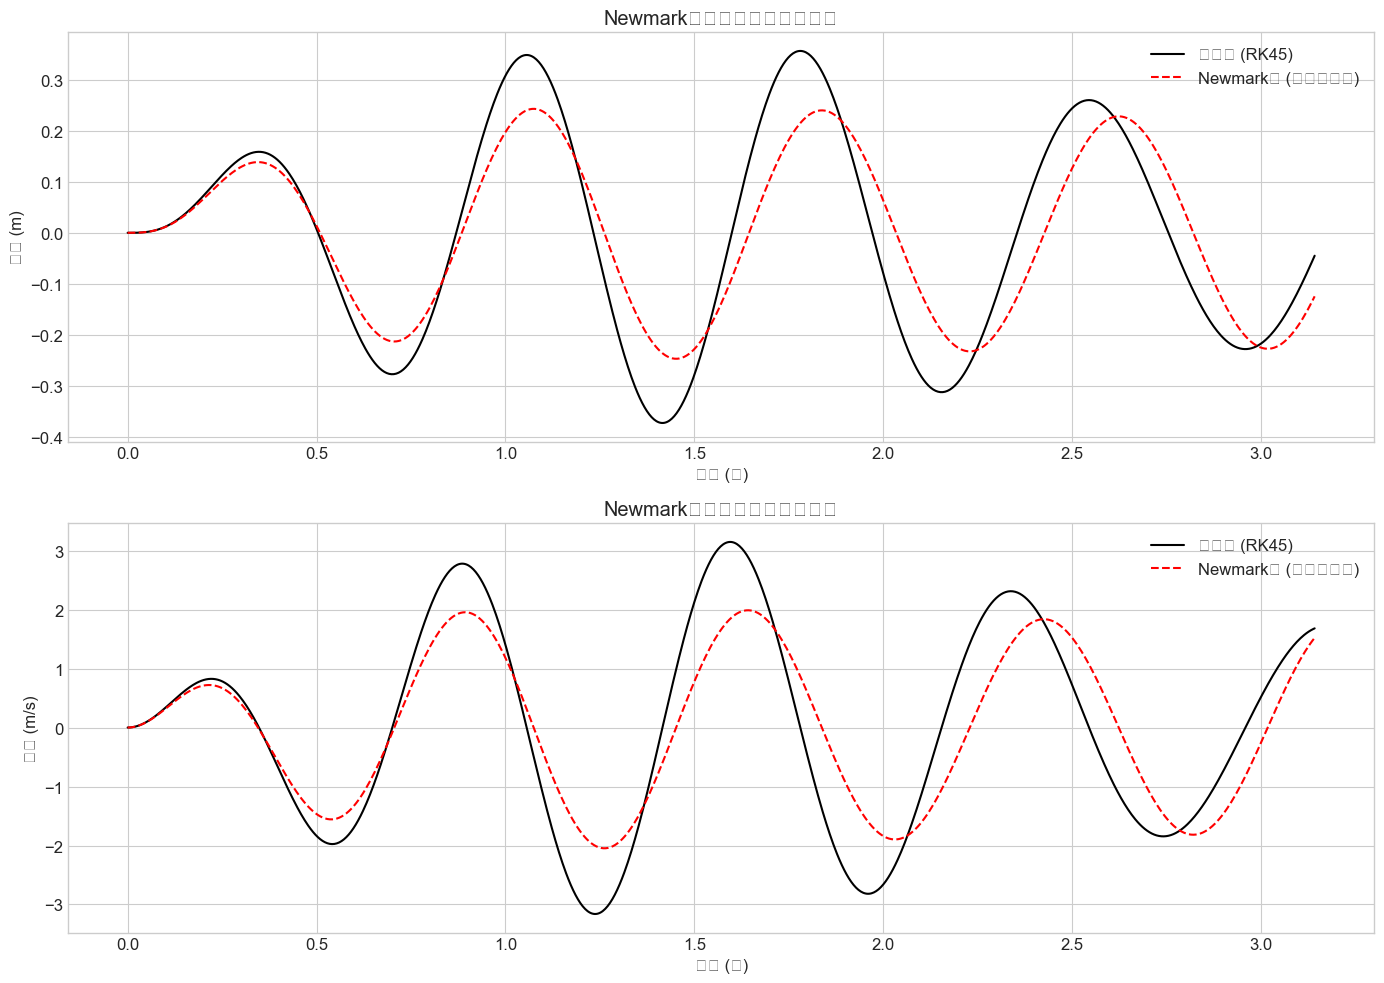

位移最大误差: 0.17106874 m
速度最大误差: 1.53166000 m/s
相对位移误差: 45.917078%


In [7]:
# 定义微分方程组 (一阶方程组形式)
def sdof_system(t, y):
    u, v = y  # y = [位移, 速度]
    dvdt = (force_function(t) - c * v - k * u) / m  # 加速度
    return [v, dvdt]

# 初始条件
y0 = [u0, v0]

# 使用scipy的高精度解法求解
sol = solve_ivp(sdof_system, [0, t_final], y0, method='RK45', rtol=1e-8, atol=1e-8, dense_output=True)

# 在与Newmark法相同的时间点上评估解
t_fine = np.linspace(0, t_final, 1000)
y_fine = sol.sol(t_fine)
u_exact = y_fine[0]
v_exact = y_fine[1]

# 使用较小步长的Newmark法结果作为对比
dt_small = T_n / 100
t_nm, u_nm, v_nm, a_nm = newmark_method(m, c, k, force_function, u0, v0, t_final, dt_small, beta_avg, gamma_avg)

# 对比可视化
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(t_fine, u_exact, 'k-', label='精确解 (RK45)')
plt.plot(t_nm, u_nm, 'r--', label='Newmark法 (平均加速度)')
plt.xlabel('时间 (秒)')
plt.ylabel('位移 (m)')
plt.title('Newmark法与精确解的位移对比')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_fine, v_exact, 'k-', label='精确解 (RK45)')
plt.plot(t_nm, v_nm, 'r--', label='Newmark法 (平均加速度)')
plt.xlabel('时间 (秒)')
plt.ylabel('速度 (m/s)')
plt.title('Newmark法与精确解的速度对比')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 计算误差
u_nm_interp = np.interp(t_fine, t_nm, u_nm)
v_nm_interp = np.interp(t_fine, t_nm, v_nm)

u_error = np.abs(u_nm_interp - u_exact)
v_error = np.abs(v_nm_interp - v_exact)

print(f"位移最大误差: {np.max(u_error):.8f} m")
print(f"速度最大误差: {np.max(v_error):.8f} m/s")
print(f"相对位移误差: {100 * np.max(u_error) / np.max(np.abs(u_exact)):.6f}%")

## 8. Newmark方法的特点总结

通过以上算例展示，我们可以总结Newmark方法的以下特点：

1. **稳定性**：
   - 当 β ≥ γ/2 ≥ 1/4 时，方法是无条件稳定的
   - 平均加速度法（β=1/4, γ=1/2）无条件稳定
   - 线性加速度法（β=1/6, γ=1/2）是条件稳定的，需要满足时间步长限制

2. **精度**：
   - 平均加速度法是二阶精度的
   - 时间步长越小，数值解越接近精确解

3. **计算效率**：
   - 作为隐式方法，每一步需要求解方程组
   - 对于线性系统，可以预先分解系统矩阵提高效率
   - 对于非线性系统，需要在每个时间步内迭代求解

4. **参数选择**：
   - β和γ参数的选择影响方法的稳定性、精度和数值阻尼
   - 常用组合：
     - β=1/4, γ=1/2：平均加速度法，无条件稳定，无数值阻尼
     - β=1/6, γ=1/2：线性加速度法，条件稳定，无数值阻尼
     - β=(2γ-1)/4, γ>1/2：引入数值阻尼的方法

5. **实际应用建议**：
   - 对于大多数结构动力学问题，平均加速度法是最常用的，因为其无条件稳定
   - 时间步长通常选择为结构最高频率周期的1/10~1/20
   - 对于需要控制高频响应的问题，可以适当引入数值阻尼

## 9. 结论

Newmark方法作为一种经典的结构动力学数值积分方法，具有实现简单、适用性广的特点。通过合理选择参数β和γ，可以在稳定性和精度之间取得平衡。在实际工程中，平均加速度法（β=1/4, γ=1/2）因其无条件稳定的特性被广泛采用。

本算例通过单自由度系统的动力响应分析，直观展示了Newmark方法的实现过程及其特性，特别是不同时间步长和参数选择对计算结果的影响。这些原理同样适用于多自由度系统分析，只需将标量方程扩展为矩阵形式。